In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pathlib

In [2]:
def project_to_sphere(x, y, shrinkage=0.8, r=1):
    # Sphere radius

    # Convert to spherical coordinates (r, theta, phi)
    # theta = np.radians(y)  # longitude in radians
    # phi = np.radians(x)  # latitude in radians

    theta = (x - x.min()) / (x.max() - x.min()) * np.pi * 2 * shrinkage
    phi = (y - y.min()) / (y.max() - y.min()) * np.pi * 2 * shrinkage

    # Convert to Cartesian coordinates (X, Y, Z)
    X = r * np.cos(theta) * np.cos(phi)
    Y = r * np.sin(theta) * np.cos(phi)
    Z = r * np.sin(phi)

    return X, Y, Z

def plot_3d(X, Y, Z, r=1):
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot sphere for reference (optional)
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x_s = r * np.outer(np.cos(u), np.sin(v))
    y_s = r * np.outer(np.sin(u), np.sin(v))
    z_s = r * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x_s, y_s, z_s, color='c', alpha=0.3)

    # Plot the projected points
    ax.scatter(X, Y, Z, c='r', marker='o')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()


In [3]:
"""Data set generator methods."""

import numpy as np


def simplex(N, **kwargs):
    """Generate set of equidistant points."""
    X = []
    C = np.linspace(0, 1, N)

    for i in range(N - 1):
        x = np.zeros((N - 1))
        x[i] = 1

        X.append(x)

    # Last point is a little bit icky...
    X.append((np.ones((N - 1)) - np.sqrt(N)) / (N - 1))

    # Make everything uniform and scale distances
    X = np.asarray(X)
    X /= np.sqrt(2)

    return X, C


def blobs(N, **kwargs):
    """Generate set of Gaussian blobs."""
    from sklearn.datasets import make_blobs

    return make_blobs(N, random_state=kwargs["random_state"])


def moons(N, **kwargs):
    """Generate moons data set with labels."""
    from sklearn.datasets import make_moons

    return make_moons(N, random_state=kwargs["random_state"])


def nested_circles(N, **kwargs):
    """Generate nested circles with labels."""
    from sklearn.datasets import make_circles

    return make_circles(N, random_state=kwargs["random_state"])


def barbell(N, beta=1, **kwargs):
    """Generate uniformly-sampled 2-D barbelll with colours."""
    if kwargs.get("random_state"):
        np.random.seed(kwargs["random_state"])

    X = []
    C = []
    k = 1

    while k <= N:
        x = (2 + beta / 2) * np.random.uniform()
        y = (2 + beta / 2) * np.random.uniform()

        n_prev = len(C)

        if (x - 0.5) ** 2 + (y - 0.5) ** 2 <= 0.25:
            C.append(0)

        elif abs(x - 1 - beta / 4) < beta / 4 and abs(y - 0.5) < 0.125:
            C.append(1)

        elif (x - 1.5 - beta / 2) ** 2 + (y - 0.5) ** 2 <= 0.25:
            C.append(2)

        if len(C) > n_prev:
            X.append((x, y))
            k += 1

    return np.asarray(X), np.asarray(C)


def double_annulus(N, **kwargs):
    """Sample N points from a double annulus."""
    if kwargs.get("random_state"):
        np.random.seed(kwargs["random_state"])

    X = []
    C = []
    for i in range(N):
        while True:
            t = [np.random.uniform(-50, 50, 1)[0], np.random.uniform(-50, 140, 1)[0]]

            d = np.sqrt(np.dot(t, t))
            if d <= 50 and d >= 20:
                X.append(t)
                C.append(0)
                break

            d = np.sqrt(t[0] ** 2 + (t[1] - 90) ** 2)
            if d <= 50 and d >= 40:
                X.append(t)
                C.append(1)
                break

    X = (X - np.min(X)) / (np.max(X) - np.min(X))
    return np.asarray(X), np.asarray(C)


def annulus(N, r, R, **kwargs):
    """Sample points from annulus.

    This function samples `N` points from an annulus with inner radius `r`
    and outer radius `R`.

    Parameters
    ----------
    N : int
        Number of points to sample

    r : float
        Inner radius of annulus

    R : float
        Outer radius of annulus

    **kwargs:
        Optional keyword arguments, such as a fixed random state for the
        pseudo-random number generator.

    Returns
    -------
    Array of (x, y) coordinates.
    """
    if r >= R:
        raise RuntimeError("Inner radius must be less than or equal to outer radius")

    if kwargs.get("random_state"):
        np.random.seed(kwargs["random_state"])

    thetas = np.random.uniform(0, 2 * np.pi, N)

    # Need to sample based on squared radii to account for density
    # differences.
    radii = np.sqrt(np.random.uniform(r ** 2, R ** 2, N))

    X = np.column_stack((radii * np.cos(thetas), radii * np.sin(thetas)))
    return X, np.linspace(0, 1, N)


def hyperuniform_circle(N, **kwargs):
    """Generate hyperuniformly-Sampled 2-D circle and colours."""
    X = []
    C = np.linspace(0, 1, N)

    theta = np.linspace(0, 2 * np.pi, N, endpoint=False)

    for t in theta:
        X.append((np.cos(t), np.sin(t)))

    return np.asarray(X), np.asarray(C)


def hyperuniform_ellipse(N, a=0.5, b=1, **kwargs):
    """Generate hyperuniformly-sampled 2-D ellipse with colours."""
    # a must be the length of minor semi-axis; b major semi-axis
    assert a < b

    X = []
    C = np.linspace(0, 1, N)

    angles = 2 * np.pi * np.arange(N) / N

    if a != b:
        # Given N points, combine scipy elliptic integral + optimize to
        # find N equidistant points along ellipse manifold, then
        # convert to angles.

        from scipy import special
        from scipy import optimize

        e = np.sqrt(1.0 - a ** 2 / b ** 2)
        tot_size = special.ellipeinc(2.0 * np.pi, e)
        arc_size = tot_size / N
        arcs = np.arange(N) * arc_size
        res = optimize.root(lambda x: (special.ellipeinc(x, e) - arcs), angles)
        angles = res.x

        arcs = special.ellipeinc(angles, e)

    for t in angles:
        X.append((a * np.cos(t), b * np.sin(t)))

    return np.asarray(X), np.asarray(C)


def linked_hyperuniform_circles(N, **kwargs):
    """Generate linked hyperuniformly-sampled 2D circles and colours."""
    X = []
    C = np.linspace(0, 1, N)

    theta = np.linspace(0, 2 * np.pi, N // 2, endpoint=False)
    theta = np.concatenate((theta, theta))

    for i, t in enumerate(theta):
        if i < N // 2:
            X.append((np.cos(t), np.sin(t)))
        # Shift the second circle away so that they are only linked at
        # a single point.
        else:
            X.append((2 + np.cos(t), np.sin(t)))

    return np.asarray(X), np.asarray(C)


def petals(N, **kwargs):
    """Generate petal data set."""
    X = []  # points in respective petals
    Y = []  # auxiliary array (points on outer circle)
    C = []

    assert N > 4, "Require more than four data points"

    # Number of 'petals' to point into the data set. This is required to
    # ensure that the full space is used.
    M = int(np.floor(np.sqrt(N)))
    thetas = np.linspace(0, 2 * np.pi, M, endpoint=False)

    for theta in thetas:
        Y.append(np.asarray([np.cos(theta), np.sin(theta)]))

    # Radius of the smaller cycles is half of the chord distance between
    # two 'consecutive' points on the circle.
    r = 0.5 * np.linalg.norm(Y[0] - Y[1])

    for i, x in enumerate(Y):
        for theta in thetas:
            X.append(np.asarray([r * np.cos(theta) - x[0], r * np.sin(theta) - x[1]]))

            # Indicates that this point belongs to the $i$th circle.
            C.append(i)

    return np.asarray(X), np.asarray(C)


def poisson_process(N, **kwargs):
    """Generate points based on a Poisson process."""
    if kwargs.get("random_state"):
        np.random.seed(kwargs["random_state"])

    n = np.random.poisson(N)
    X = np.random.rand(n, 2)
    C = np.linspace(0, 1, n)

    return X, C


def const_curvature_disk(N, K, **kwargs):
    """Sample points on manifolds of constant curvature."""

    if np.isclose(K, 0):
        return euclidean_disk(N, **kwargs)
    else:
        return spherical_cap(N, K, **kwargs) if K > 0 else hyperbolic_disk(N, K, **kwargs)


def euclidean_disk(N, **kwargs):
    """Sample points on a unit Euclidean disk."""

    if kwargs.get("random_state"):
        np.random.seed(kwargs["random_state"])

    u = np.random.uniform(0, 1, N)
    r = np.sqrt(u)
    theta = np.random.uniform(0, 2 * np.pi, N)
    x = np.multiply(r, np.cos(theta))
    y = np.multiply(r, np.sin(theta))
    C = np.linspace(0, 1, N)

    return np.vstack([x, y]).T, C


def spherical_cap(N, K, **kwargs):
    """Sample points from a unit disk on the surface of a sphere with const. positive curvature K."""

    if kwargs.get("random_state"):
        np.random.seed(kwargs["random_state"])

    assert K > 0

    u = np.random.uniform(0, 1, N)
    r = np.multiply(np.sqrt(u), np.sin(np.sqrt(K) / 2.0))
    r = np.multiply(2.0 / np.sqrt(K), np.arcsin(r))
    theta = np.random.uniform(0, 2 * np.pi, N)
    x = np.multiply(r, np.cos(theta))
    y = np.multiply(r, np.sin(theta))
    C = np.linspace(0, 1, N)

    return np.vstack([x, y]).T, C


def hyperbolic_disk(N, K, **kwargs):
    """Sample points from a hyperbolic disk (using the Poincaré metric) with const. negative curvature K."""

    if kwargs.get("random_state"):
        np.random.seed(kwargs["random_state"])

    assert K < 0

    u = np.random.uniform(0, 1, N)
    r = np.multiply(np.sqrt(u), np.sinh(np.sqrt(-K) / 2.0))
    r = np.multiply(2.0 / np.sqrt(-K), np.arcsinh(r))
    theta = np.random.uniform(0, 2 * np.pi, N)
    x = np.multiply(r, np.cos(theta))
    y = np.multiply(r, np.sin(theta))
    C = np.linspace(0, 1, N)

    return np.vstack([x, y]).T, C


def torus(N, inner_radius=3, outer_radius=10):
    """Generate n-point hollow torus with one hole."""

    # begin by generating a hollow cylinder
    # from N random uniform points, normalized so that y^2 + z^2 = inner_radius^2
    X = np.random.rand(N, 3) * 2 - 1
    X[:, 1:] /= np.sqrt(np.sum(X[:, 1:] ** 2, axis=1))[:, None] / inner_radius
    x, y, z = X.T
    # Twist the cylinder
    # first, shift the cylinder on the y axis so that 0,0,0 lies at the center of the soon-to-be constructed donut
    rod_length = outer_radius - inner_radius
    y += outer_radius
    # Transform into polar coordinates around Z axis
    r = np.sqrt(x ** 2 + y ** 2)
    theta = (
        x * 2 * np.pi
    )  # we can disregard the previous angle, which didn't mean anything
    # Back to cartesian coords
    x = np.cos(theta) * r
    y = np.sin(theta) * r

    # Recombine the variables
    X = np.column_stack((x, y, z))
    return X


def sphere(N, dim=3):
    """Generate N-point sphere with specified dimension. A wrapper for tadasets

    Args:
        N (int): Number of points
        dim (int, optional): Dimension of sphere. Defaults to 3.
    """
    import tadasets

    dsphere = tadasets.dsphere(
        n=N, d=dim - 1, r=1
    )  # TODO: Can also specify the amount of noise to add to the sphere
    return dsphere


In [4]:
DATASETS = (barbell, blobs, double_annulus, hyperuniform_circle, petals, simplex)

In [5]:
N = 128
seed = 2021

In [6]:
Xdat, _ = DATASETS[4](N, random_state=seed)

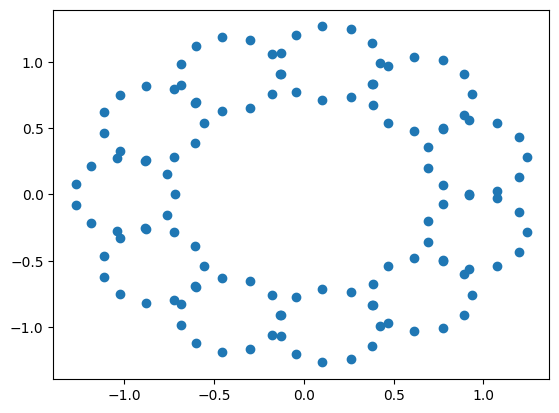

In [7]:
plt.scatter(Xdat[:, 0], Xdat[:, 1])
plt.show()

In [8]:
x1,y1,z1 = project_to_sphere(Xdat[:, 0], Xdat[:, 1],.8)

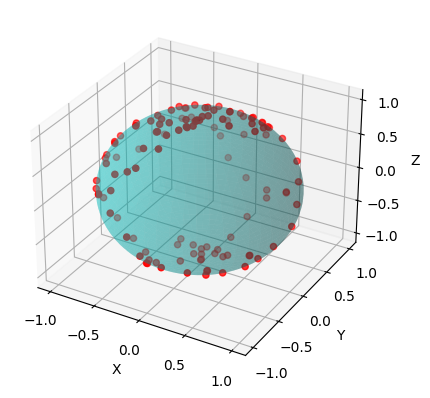

In [9]:
plot_3d(x1,y1,z1)

In [ ]:
pathlib.Path("sphere").mkdir(exist_ok=True)

In [ ]:
# save datasets
for ds in DATASETS:
    Xdat, _ = DATASETS[4](N, random_state=seed)
    x1,y1,z1 = project_to_sphere(Xdat[:, 0], Xdat[:, 1],.8,2)
    data = np.c_[x1, y1, z1]
    np.savetxt(f"sphere/{ds.__name__}", data)

In [ ]:
DATASETS[0].__name__

'barbell'